<a href="https://colab.research.google.com/github/aamyren/TF-training/blob/main/Multi-Digit_MNIST_with_Shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

TensorFlow version: 2.8.2


In [ ]:
# helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")


In [ ]:
x_train.shape

(60000, 28, 28, 1)

In [ ]:
# function to combine two indexes of data in each list
def combine(xdata, ydata, a, b):
    ny = int(10*ydata[a] + ydata[b])
    nx = np.hstack((xdata[a],xdata[b]))
    nx = nx[:, ::2]
    # print(ny)
    return nx, ny

In [ ]:
# creates list of random indexes a certain length to combine
def randlist(size):
    rlist = list(range(size))
    random.shuffle(rlist)
    return rlist

In [ ]:
nx_test = np.empty((1000, 28, 28, 1))
ny_test = np.empty(1000)

a = randlist(1000)
for i in range(0, 1000):
    x, y = combine(x_test, y_test, a[i], a[i-1])
    ny_test[i] = y 
    nx_test[i] = x

#print(ny_test)

nx_train = np.empty((60000, 28, 28, 1))
ny_train = np.empty(60000)

a = randlist(60000)
for i in range(0, 60000):
    x, y = combine(x_train, y_train, a[i], a[i-1])
    ny_train[i] = y 
    nx_train[i] = x

#print(ny_test)

In [ ]:
def shift(img):
    seed = random.randrange(0,1)

    new = np.roll(img, 4, seed)
    return new

for i in range(1000):
    nx_test[i] = shift(nx_test[i])

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (nx_train, ny_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((nx_test, ny_test)).batch(32)

In [ ]:
print(ny_train)
ny_train[-4]

[71. 97. 39. ... 90. 99. 19.]


1.0

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(100)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.7732685804367065, Accuracy: 78.28166198730469, Test Loss: 6.805253982543945, Test Accuracy: 5.900000095367432
Epoch 2, Loss: 0.22296975553035736, Accuracy: 93.27666473388672, Test Loss: 6.36251163482666, Test Accuracy: 10.800000190734863
Epoch 3, Loss: 0.1300535351037979, Accuracy: 95.86000061035156, Test Loss: 6.7402777671813965, Test Accuracy: 13.09999942779541
Epoch 4, Loss: 0.07958143949508667, Accuracy: 97.46666717529297, Test Loss: 7.314238548278809, Test Accuracy: 14.200000762939453
Epoch 5, Loss: 0.052256181836128235, Accuracy: 98.29499816894531, Test Loss: 8.177607536315918, Test Accuracy: 14.5


In [ ]:
# The test accuracy is much lower from the shifted data because the neural network is initially only trained on the centered images. 
# The shifted/cropped test images have not been trained with the network and are therefore more difficult to read.

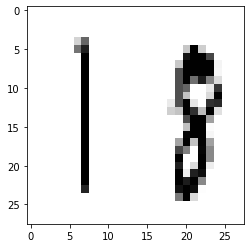

In [ ]:
nx_train = np.resize(nx_train, (6000, 28, 28))
plt.figure()
plt.imshow(nx_train[1000], cmap = plt.cm.binary)

In [ ]:
nx_train.shape


(6000, 28, 28)

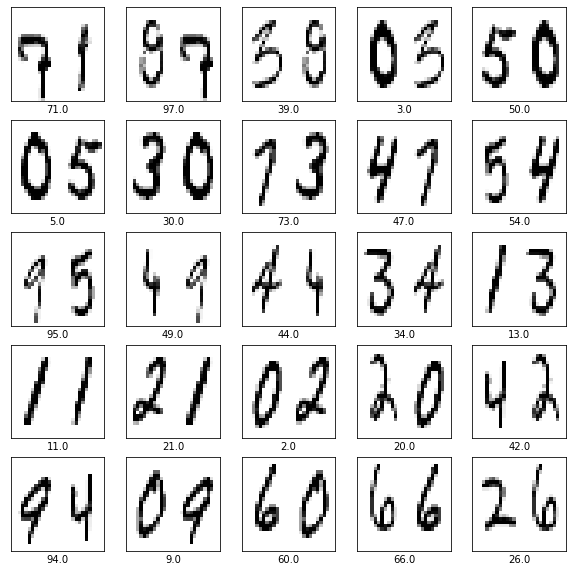

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(nx_train[i], cmap=plt.cm.binary)
    plt.xlabel(ny_train[i])
plt.show()

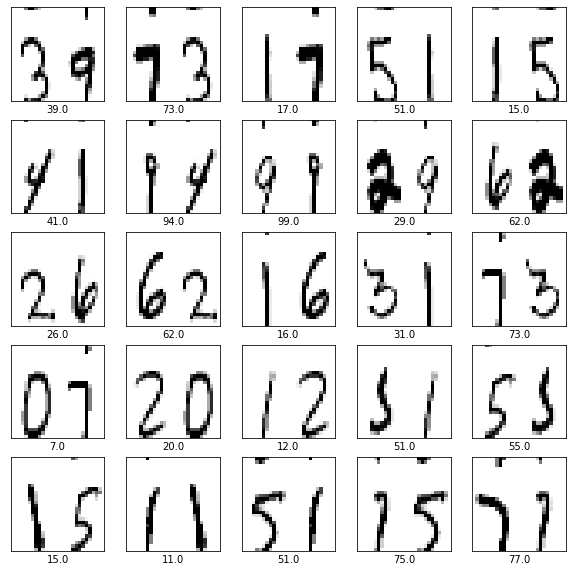

In [ ]:
nx_test = np.resize(nx_test, (6000, 28, 28))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(nx_test[i], cmap=plt.cm.binary)
    plt.xlabel(ny_test[i])
plt.show()